# Imports & constants

In [ ]:
from pathlib import Path
from Bio import SeqIO
from pyteomics import fasta, mzml
import sqlite3
from src.plot_utils import fig_setup, finalize, set_title_axes_labels
import time
import matplotlib.pyplot as plt
from pydantic import BaseModel
import numpy as np
from scipy import stats
from collections import Counter
import pandas as pd
import sys
import subprocess
import more_itertools
from src.erik import *
from typing import Union
from concurrent.futures import ThreadPoolExecutor
from objsize import get_deep_size

GIT_REPO_DIR = Path("/Users/erjo3868/repos/hypedsearch/hypedsearch")
PLOTS_DIR = GIT_REPO_DIR / "plots"
DATA_DIR = GIT_REPO_DIR / "data"
COMET_RUN_1_DIR = DATA_DIR / "comet_run_1"

SPECTRA_DIR = DATA_DIR / "spectra"
ID = "id"
DESC = "description"
IDX_MASS = "idx_mass"
COMET_DIR = DATA_DIR / "comet_run_1"
HS_DIR = DATA_DIR / "hs"
KMERS_DB_FILE = "kmers.db"
KMERS = "kmers"
MAX_PEPTIDE_LEN = 50

# samples = ["BMEM_AspN_Fxn5"] # single sample
samples = [f"BMEM_AspN_Fxn{val}" for val in [4, 5, 6, 7, 8, 9]] # multiple samples

# EDA

In [ ]:
# Comet data
file_path = COMET_DIR / (samples[0] + ".txt")
file_path
df = pd.read_csv(file_path, sep="\t", header=1)

df[df["ions_matched"]>2]

PosixPath('/Users/erjo3868/repos/hypedsearch/hypedsearch/data/comet_run_1/BMEM_AspN_Fxn4.txt')

,scan,num,charge,exp_neutral_mass,calc_neutral_mass,e-value,xcorr,delta_cn,sp_score,ions_matched,ions_total,plain_peptide,modified_peptide,prev_aa,next_aa,protein,protein_count,modifications,retention_time_sec,sp_rank
0,1,1,4,1365.712074,1363.695173,12.1,0.4665,0.1686,1.8,2,60,TCTMSLKPRVV,-.TC[57.0215]TM[15.9949]SLKPRVV.D,-,D,tr|Q571A2|Q571A2_MOUSE,1,"2_S_57.021464,2_V_57.021460,4_V_15.994900",694.0,5
1,1,2,4,1365.712074,1362.689178,36.7,0.3879,0.3983,1.4,2,78,DAANGIASGSFRVV,P.DAANGIASGSFRVV.D,P,D,"sp|Q9JHI2|ADAT1_MOUSE,sp|Q9JHI2-2|ADAT1_MOUSE,...",4,-,694.0,11


,scan,num,charge,exp_neutral_mass,calc_neutral_mass,e-value,xcorr,delta_cn,sp_score,ions_matched,ions_total,plain_peptide,modified_peptide,prev_aa,next_aa,protein,protein_count,modifications,retention_time_sec,sp_rank
10,3,1,4,1365.714430,1364.704828,53.70,0.4159,0.1399,6.0,4,84,DAVARATGPAPGPSV,S.DAVARATGPAPGPSV.D,S,D,"sp|Q7TSJ2|MAP6_MOUSE,tr|D3Z6W1|D3Z6W1_MOUSE,sp...",3,-,694.0,1
11,3,2,4,1365.714430,1362.703097,122.00,0.3577,0.0755,3.9,3,66,DEDKIGVFKDVV,G.DEDKIGVFKDVV.D,G,D,"DECOY_sp|P97493|THIOM_MOUSE,DECOY_tr|G3UZY2|G3...",2,-,694.0,2
14,3,5,4,1365.714430,1364.708851,410.00,0.2718,0.0744,3.5,3,66,DFSVLRLYAQPG,C.DFSVLRLYAQPG.D,C,D,sp|Q9EP78|CHST7_MOUSE,1,-,694.0,4
15,4,1,5,2523.272153,2523.294232,3.64,0.9552,0.1165,5.1,4,132,DNAGPHQRPFLKSSASEKRSKPS,T.DNAGPHQRPFLKSSASEKRSKPS.-,T,-,DECOY_tr|G3UZ11|G3UZ11_MOUSE,1,-,707.0,13
16,4,2,5,2523.272153,2523.267911,11.20,0.8439,0.0036,3.7,4,126,DTLTARGTYIYRLLMTFAEATT,Q.DTLTARGTYIYRLLM[15.9949]TFAEATT.D,Q,D,"DECOY_sp|Q8C726|BTBD9_MOUSE,DECOY_tr|A0A494B98...",8,15_V_15.994900,707.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23537,5107,1,4,3721.721994,3718.745456,12.20,0.8288,0.0121,4.0,4,192,DLTMLEHQKATENLEYTQILQQACALTAGDEGQ,E.DLTMLEHQKATENLEYTQILQQACALTAGDEGQ.D,E,D,DECOY_sp|Q8K2J0|PLCD3_MOUSE,1,24_S_57.021464,2852.0,6
23538,5107,2,4,3721.721994,3720.728231,13.30,0.8187,0.0394,2.6,4,192,MDMHCKADPFSAMHRHGGVNQLGGVFVNGRPLP,-.M[15.9949]DMHC[57.0215]KADPFSAM[15.9949]HRHG...,-,D,"sp|P32114|PAX2_MOUSE,tr|G3X8Q7|G3X8Q7_MOUSE,sp...",4,"1_V_15.994900,5_S_57.021464,5_V_57.021460,13_V...",2852.0,13
23539,5107,3,4,3721.721994,3720.723739,17.40,0.7865,0.0145,1.8,3,180,DNYAASFSLVVISCIMCVSIMYIYGHRNYFQ,M.DNYAASFSLVVISCIMCVSIMYIYGHRNYFQ.D,M,D,"sp|P28571|SC6A9_MOUSE,tr|E9Q3V0|E9Q3V0_MOUSE,t...",5,"14_S_57.021464,17_S_57.021464",2852.0,30
23540,5107,4,4,3721.721994,3719.738499,19.20,0.7751,0.0042,1.6,4,234,DISVLPTGGESLETSASGVGDLSGLPSGGESLETSASGAE,E.DISVLPTGGESLETSASGVGDLSGLPSGGESLETSASGAE.D,E,D,sp|Q61282|PGCA_MOUSE,1,-,2852.0,36


In [37]:
result = subprocess.run("ls -la", shell=True, capture_output=True)
result.returncode
result.stdout
result.stderr


0

b'total 1048\ndrwxr-xr-x@ 21 erjo3868  staff     672 Nov  1 14:19 \x1b\x1b.\x1b[m\x1b[m\ndrwxr-xr-x@  5 erjo3868  staff     160 Oct 27 23:00 \x1b\x1b..\x1b[m\x1b[m\n-rw-r--r--@  1 erjo3868  staff    6148 Oct 27 23:00 .DS_Store\ndrwxr-xr-x@ 15 erjo3868  staff     480 Oct 10 14:25 \x1b\x1b.git\x1b[m\x1b[m\ndrwxr-xr-x@  3 erjo3868  staff      96 Sep 24 15:22 \x1b\x1b.github\x1b[m\x1b[m\n-rw-r--r--@  1 erjo3868  staff    1967 Oct  8 12:33 .gitignore\ndrwxr-xr-x@  4 erjo3868  staff     128 Oct 10 15:24 \x1b\x1b.ipynb_checkpoints\x1b[m\x1b[m\ndrwxr-xr-x@  6 erjo3868  staff     192 Oct  8 13:17 \x1b\x1b.pytest_cache\x1b[m\x1b[m\n-rw-r--r--@  1 erjo3868  staff       8 Sep 24 15:40 .python-version\ndrwxr-xr-x@  6 erjo3868  staff     192 Sep 24 16:16 \x1b\x1b.venv\x1b[m\x1b[m\ndrwxr-xr-x@  3 erjo3868  staff      96 Oct  8 13:17 \x1b\x1b.vscode\x1b[m\x1b[m\n-rw-r--r--@  1 erjo3868  staff    1069 Sep 24 15:22 LICENSE\n-rw-r--r--@  1 erjo3868  staff    8982 Sep 24 15:22 README.md\ndrwxr-xr-x@  5 er

b''

In [ ]:
import sqlite3 # in standard library

# db_file = REPO_DIR / "mouse_proteome.db"
db_file = ":memory:"
connection = sqlite3.connect(db_file)
cursor = connection.cursor()
res = cursor.execute("SELECT name FROM sqlite_master")
print(res.fetchone())

cursor.execute(
    """
    CREATE TABLE kmers (
        mass REAL,
        location_start INTEGER,
        location_end INTEGER,
        ion TEXT,
        charge INTEGER,
        protein INTEGER
    )
    """
)
cursor.execute(
    f"""
    CREATE TABLE proteins (
        {ID} INTEGER,
        {DESC} TEXT,
        {SEQ} TEXT
    )
    """
)
res = cursor.execute("SELECT name FROM sqlite_master")
print(res.fetchone())
fasta_file = GIT_REPO_DIR / "comet/Uniprot_mouse.fasta"

proteins = [
    {ID: protein_num, SEQ: str(protein.seq), DESC: protein.description} 
    for protein_num, protein in enumerate(SeqIO.parse(fasta_file, "fasta"))
]
cursor.executemany("INSERT INTO proteins VALUES(:id, :description, :sequence)", proteins)
connection.commit()

# res = cursor.execute("SELECT * FROM proteins WHERE id BETWEEN 1 AND 10")
# res.fetchall()
query = "SELECT * FROM proteins WHERE id BETWEEN 1 AND 10"
pd.read_sql_query(query, connection)



connection.close()

None


('kmers',)


,id,description,sequence
0,1,tr|A0A0R4J1Z0|A0A0R4J1Z0_MOUSE MAS-related GPR...,MGESNGEAFLAFKTSASPTAPVTTNPMDETLPGSINIRILIPKLMI...
1,2,"tr|A0A3B2WB67|A0A3B2WB67_MOUSE Vomeronasal 2, ...",MYFTFNCLFLLLQSLFTPVEMTRKSCYEFWNPSTYMKADIILGAFI...
2,3,tr|A0A668KLT6|A0A668KLT6_MOUSE Predicted gene ...,MNSSSEHCNVSDWLRLEATVKASVYVVAFSITTSLTVVIIAIVSQS...
3,4,sp|A2ANU3|SYNG1_MOUSE Synapse differentiation-...,MDGIIEQKSVLVHSKISDAGKRNGLINTRNFMAESRDGLVSVYPAP...
4,5,tr|A2RSF9|A2RSF9_MOUSE Serine (Or cysteine) pe...,MILFPEADGKFTVEMYRQLRESDKNIFYSPISMITALGMLKLGAKG...
5,6,"tr|B1AR69|B1AR69_MOUSE Myosin, heavy polypepti...",MSSDAEMAIFGEAAPYLRKPEKERIEAQNRPFDSKKACFAVDDKEM...
6,7,tr|B1AUV6|B1AUV6_MOUSE Predicted gene 12790 OS...,MGFQDLPTLQQLAIQGLASNEDTAVSALKDLPKVFFPLLFKNAFIK...
7,8,tr|D3Z3H0|D3Z3H0_MOUSE INO80 complex subunit E...,MNGPADGEVDYKKKYRNLKRKLKFLIYEHECFQEELRKAQRKLLKV...
8,9,"tr|E9PYS0|E9PYS0_MOUSE Vomeronasal 2, receptor...",MFSCIFISSLLLIAKFVLTFMHVNISKCFYKITEDFHHEGDVVIGA...
9,10,tr|E9Q3K0|E9Q3K0_MOUSE Coiled-coil domain cont...,MESQGQSYPKWNTKGRRATIFPQREGAKTLIPSAIPAQLEETAFLT...


# K-mer Database

In [ ]:
# Get all proteins from FASTA file
fasta_file = GIT_REPO_DIR / "comet/Uniprot_mouse.fasta"
proteins = [
    {ID: protein_num, SEQ: str(protein.seq), DESC: protein.description} 
    for protein_num, protein in enumerate(SeqIO.parse(fasta_file, "fasta"))
]


In [ ]:
def generate_kmers(sequence: str, max_len: int = MAX_PEPTIDE_LEN):
    disallowed_amino_acid_symbols = ["B", "X", "U", "Z", "O", "J"]
    for length in range(1, max_len + 1):  # Generate k-mers of length 1 to max_len
        for i in range(len(sequence) - length + 1):
            kmer = sequence[i:i + length]
            if any(char in disallowed_amino_acid_symbols for char in kmer):
                continue
            yield {SEQ: kmer, MASS: compute_theoretical_mass(peptide=kmer)} # Yield each k-mer

# Create DB
connection = sqlite3.connect(db_file, timeout=10)
cursor = connection.cursor()

_=cursor.execute("DROP TABLE IF EXISTS kmers")
_=cursor.execute(
    f"""
    CREATE TABLE kmers (
        {SEQ} TEXT PRIMARY KEY,
        {MASS} REAL
    )
    """
)

num_proteins = len(proteins)
t0 = time.time()
for p_num, protein in enumerate(proteins):
    if (p_num+1) % 10 == 0:
        print(f"Protein {p_num+1} / {num_proteins}, {round(time.time()-t0, 2)} seconds")
    data = generate_kmers(sequence=protein[SEQ])

    _=cursor.executemany(f"INSERT OR IGNORE INTO kmers VALUES(:{SEQ}, :{MASS})", data)
    _=connection.commit()

connection.close()

('kmers',)
Protein 10 / 21759, 1.15 seconds
Protein 20 / 21759, 3.35 seconds
Protein 30 / 21759, 5.06 seconds
Protein 40 / 21759, 7.33 seconds
Protein 50 / 21759, 10.29 seconds
Protein 60 / 21759, 11.57 seconds
Protein 70 / 21759, 14.61 seconds
Protein 80 / 21759, 16.23 seconds
Protein 90 / 21759, 17.1 seconds
Protein 100 / 21759, 18.44 seconds
Protein 110 / 21759, 20.64 seconds
Protein 120 / 21759, 22.62 seconds
Protein 130 / 21759, 24.41 seconds
Protein 140 / 21759, 28.56 seconds
Protein 150 / 21759, 32.77 seconds
Protein 160 / 21759, 34.33 seconds
Protein 170 / 21759, 36.21 seconds
Protein 180 / 21759, 38.43 seconds
Protein 190 / 21759, 39.29 seconds
Protein 200 / 21759, 41.64 seconds
Protein 210 / 21759, 43.57 seconds
Protein 220 / 21759, 46.18 seconds
Protein 230 / 21759, 47.84 seconds
Protein 240 / 21759, 49.64 seconds
Protein 250 / 21759, 51.82 seconds
Protein 260 / 21759, 55.13 seconds
Protein 270 / 21759, 58.33 seconds
Protein 280 / 21759, 61.57 seconds
Protein 290 / 21759, 63

## Establish and close connection to db

In [34]:
connection = sqlite3.connect(KMERS_DB_FILE)
cursor = connection.cursor()

In [11]:
connection.close()

## Create mass index

In [ ]:
connection = sqlite3.connect(KMERS_DB_FILE)
cursor = connection.cursor()
# Create an index on the REAL column (price)
cursor.execute(f"CREATE INDEX IF NOT EXISTS {IDX_MASS} ON {KMERS}({MASS});")
connection.commit()  # Commit the index creation
connection.close()

SyntaxError: unterminated string literal (detected at line 5) (98430829.py, line 5)

## Get information about db

In [4]:
t0 = time.time()
_=cursor.execute(f"SELECT COUNT(*), MAX(LENGTH({SEQ})), MIN({MASS}), MAX({MASS}) FROM {KMERS};")
kmer_count, max_kmer_len, min_kmer_mass, max_kmer_mass = cursor.fetchall()[0]
duration_sec = round(time.time() - t0, 2)
print(f"Query took {duration_sec} seconds, {duration_sec/60} minutes")
print((
    f"Stats on {KMERS_DB_FILE}:\n"
    f"\t- num kmers = {kmer_count}\n"
    f"\t- min kmer mass = {min_kmer_mass}\n"
    f"\t- max kmer mass = {max_kmer_mass}\n"
    f"\t- max kmer length = {max_kmer_len}"
))

Query took 121.86 seconds, 2.031 minutes
Stats on kmers.db:
	- num kmers = 480040136
	- min kmer mass = 57.021464
	- max kmer mass = 7109.124191000004
	- max kmer length = 50


## Number of k-mers per mass

In [ ]:
len([mass for mass in range(50, 5000, 10)])

masses = range(50, 7001, 10)
mass, tol = 100, 10
query = get_query_to_select_rows_by_mass(mass=mass, tolerance=tol)

queries = [
    get_query_to_select_rows_by_mass(mass=mass, tolerance=tol) for mass in masses
]
# query_database(query=query, db_path=KMERS_DB_FILE)[0]

495

In [ ]:
# Non-parallel way
connection = sqlite3.connect(KMERS_DB_FILE)
cursor = connection.cursor()

t0 = time.time()
results = []
for mass in masses:
    print(f"mass = {mass}")
    results.append(get_mass_matching_kmers(mass=mass, db_cursor=cursor, tolerance=tol))
t1 = time.time()
print(f"Took {round(t1-t0, 2)} seconds")
connection.close()


mass = 50
mass = 60
mass = 70
mass = 80
mass = 90
mass = 100
mass = 110
mass = 120
mass = 130
mass = 140
mass = 150
mass = 160
mass = 170
mass = 180
mass = 190
mass = 200
mass = 210
mass = 220
mass = 230
mass = 240
mass = 250
mass = 260
mass = 270
mass = 280
mass = 290
mass = 300
mass = 310
mass = 320
mass = 330
mass = 340
mass = 350
mass = 360
mass = 370
mass = 380
mass = 390
mass = 400
mass = 410
mass = 420
mass = 430
mass = 440
mass = 450
mass = 460
mass = 470
mass = 480
mass = 490
mass = 500
mass = 510
mass = 520
mass = 530
mass = 540
mass = 550
mass = 560
mass = 570
mass = 580
mass = 590
mass = 600
mass = 610
mass = 620
mass = 630
mass = 640
mass = 650
mass = 660
mass = 670
mass = 680
mass = 690
mass = 700
mass = 710
mass = 720
mass = 730
mass = 740
mass = 750
mass = 760
mass = 770
mass = 780
mass = 790
mass = 800
mass = 810
mass = 820
mass = 830
mass = 840
mass = 850
mass = 860
mass = 870
mass = 880
mass = 890
mass = 900
mass = 910
mass = 920
mass = 930
mass = 940
mass = 950
mass

In [113]:
# Parallel way
t0 = time.time()
with ThreadPoolExecutor() as executor:
    results = list(executor.map(lambda query: query_database(query=query, db_path=KMERS_DB_FILE)[0][0], queries))
t1 = time.time()
print(f"Took {round(t1-t0, 2)} seconds")

Took 3.87 seconds


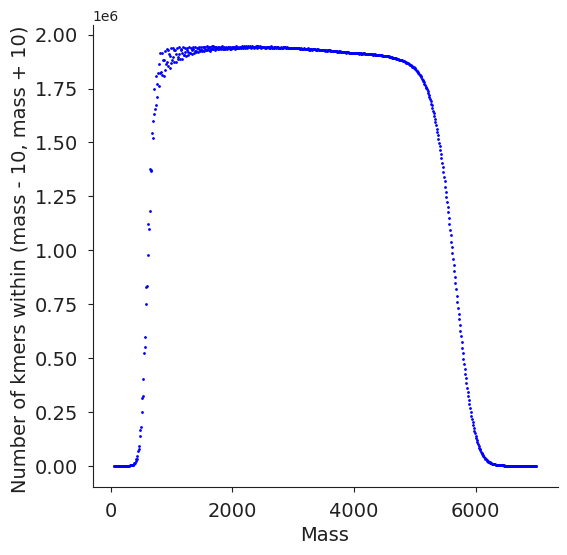

In [115]:
_, axs = fig_setup(1, 1, w=6, h=6)
_ = axs[0].plot(
    list(masses), results,
    'b.',
    ms=2
)
set_title_axes_labels(axs[0], xlabel="Mass", ylabel=f"Number of kmers within (mass - {tol}, mass + {tol}) ")
finalize(axs)
plt.savefig(PLOTS_DIR / f"kmers_per_mass_tol={tol}.png", dpi=300, bbox_inches="tight")


# PSMs

[<Axes: xlabel='m/z', ylabel='intensity'>]

((86.05862426757812,
  114.0555191040039,
  129.10386657714844,
  163.97869873046875,
  186.57936096191406),
 (183.88999938964844,
  715.2930908203125,
  253.46778869628906,
  151.06532287597656,
  81.33333587646484))

[<Axes: xlabel='m/z', ylabel='intensity'>]

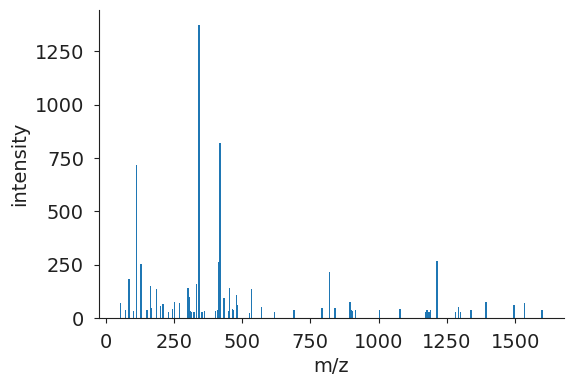

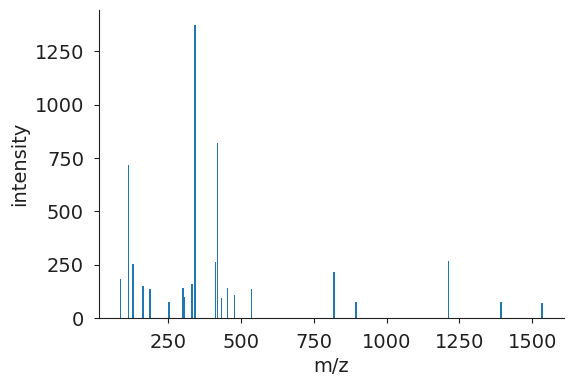

In [ ]:
sample = samples[0]

mzml_path = SPECTRA_DIR / f"{sample}.mzML"

spectra = read_mzml(mzml_path)
spectrum = next(spectra)

plot_mass_spectrum(spectrum)

masses, abundances = relative_abundance_filtering(
    mass_over_charges=spectrum.mass_over_charges, 
    abundances=spectrum.abundances,
    rel_abundance_cutoff=0.05
)
masses[:5], abundances[:5]
spectrum.mass_over_charges = masses
spectrum.abundances = abundances

plot_mass_spectrum(spectrum)




In [ ]:
t0 = time.time()
data = []
print(f"There are {len(spectrum.mass_over_charges)} masses")
for mass_idx, mass in enumerate(spectrum.mass_over_charges):
    t1 = time.time()
    get_mass_matching_kmers(mass=mass, db_cursor=cursor)
    if (mass_idx + 1) % 2 == 0:
        print(f"\t {round(time.time()-t1, 2)} secs")
print(f"Total time: {round(time.time()-t0, 2)} secs")

There are 27 masses
	 0.0 secs
	 0.0 secs
	 0.0 secs
	 0.01 secs
	 0.0 secs
	 0.02 secs
	 0.35 secs
	 0.17 secs
	 0.09 secs
	 0.58 secs
	 2.22 secs
	 11.34 secs
	 16.91 secs
Total time: 77.25 secs


# Read spectra

In [ ]:
# sample = "BMEM_AspN_Fxn5"
mzml_paths = [SPECTRA_DIR / f"{sample}.mzML" for sample in samples]
total_num_spectra = 0
for file_num, mzml_path in enumerate(mzml_paths):
    print(f"Reading {mzml_path.stem} ({file_num+1}/{len(mzml_paths)})")
    t0 = time.perf_counter()
    # Parse spectra
    spectra = mzml.read(str(mzml_path))
    # spectra = [
    #     parse_spectrum(spectrum=spectrum)
    #     for spectrum_num, spectrum in enumerate(mzml.read(str(mzml_path)))
    # ]
    # Count spectra
    total_num_spectra += len(list(spectra))
    t1 = time.perf_counter()
    print(f"\tTook {t1-t0:.2f} seconds")
    # break

print(f"There are {total_num_spectra} spectra")

# Plot mass spectrum

In [ ]:
fig, axs = fig_setup(nrows=1, ncols=2)
mz_values = list(spectra[0].mass_to_charges)
abundances = list(spectra[0].abundances)

_=axs[0].stem(mz_values, abundances)
_=axs[1].bar(mz_values, abundances, width=5)
_=set_title_axes_labels(axs[1], xlabel="m/z", ylabel="intensity")
[finalize(axs) for ax in axs]
plt.tight_layout()
plt.savefig("./spectrum.png")

# Functions and classes

In [ ]:
from typing import List

import pandas as pd
from pydantic import BaseModel, field_validator, model_validator



# Abundances of left and right kmers in Comet run 1 output

## Read data

In [23]:
comet_data, hs_data = [], []

for sample in samples:
    print(f"Reading data for {sample}")
    comet_output = COMET_DIR / f"{sample}.txt"
    hs_output = HS_DIR / f"HS_{sample}.txt"
    comet_data.extend(CometResult.from_txt(comet_output))
    hs_data.extend(HSResult.from_txt(hs_output))

Reading data for BMEM_AspN_Fxn4
Reading data for BMEM_AspN_Fxn5
Reading data for BMEM_AspN_Fxn6
Reading data for BMEM_AspN_Fxn7
Reading data for BMEM_AspN_Fxn8
Reading data for BMEM_AspN_Fxn9


## EDA

In [24]:
comet_data[0]

CometResult(sample='BMEM_AspN_Fxn4', scan=1, ions_matched=2, proteins=['tr|Q571A2|Q571A2_MOUSE'], protein_count=1)

Get abundances of proteins in Comet data

In [ ]:
from collections import Counter
# Get abundances of non-decoy proteins
proteins = [protein for row in comet_data for protein in row.proteins]
proteins = [protein for protein in proteins if "DECOY" not in protein]
# Protein names in Comet are "<str1>|<str2>|<str3>"
# Update them to just be "<str3>" to match HS's output
proteins = [protein.split("|")[2] for protein in proteins]
comet_protein_abundance = Counter(proteins)


In [ ]:
min(comet_protein_abundance.values())
max(comet_protein_abundance.values())

## Distribution of protein abundances in Comet run 1

In [ ]:
fig, axs = fig_setup(1, 1)
counts, bins, patches = axs[0].hist(
    comet_protein_abundance.values(),
    bins=max(comet_protein_abundance.values()),
    # edgecolor='black'
)
_=axs[0].set_ylim(top=10)


_=axs[0].set_xticks([round(bin) for bin in bins[::10]])
_=axs[0].tick_params(axis="x", labelsize=7, labelrotation=90)
set_title_axes_labels(
    axs[0], 
    ylabel="Number of proteins with given abundance",
    xlabel="Protein abundance in Comet run 1",
    title=f"Num MZMLs = {len(samples)}"
)
_=axs[0].set_yticks(np.arange(0, 10, 1))
_=axs[0].grid()

# Plot empirical CDF of counts
fig, axs = fig_setup(1, 1)
ecdf = stats.ecdf(list(comet_protein_abundance.values()))
ecdf.cdf.plot(axs[0])
set_title_axes_labels(
    axs[0],
    xlabel="Protein abundances in Comet run 1 output",
    ylabel="Empirical CDF",
)
_=axs[0].set_yticks(np.arange(0, 1, 0.1))
_=axs[0].set_xticks(np.arange(0, 260, 20))
_=axs[0].grid()


For each HS-identified hybrid peptide, get the abundances in the Comet output of the left and right kmer.

In [ ]:
HS_RESULT = "hs_result"
LEFT_ABS, RIGHT_ABS = "left_abs", "right_abs"
hybrid_df = []
for hs_row in hs_data:
    if hs_row.hybrid is False:
        continue
    left_abs = [comet_protein_abundance.get(kmer, 0) for kmer in hs_row.left_kmers]
    right_abs = [comet_protein_abundance.get(kmer, 0) for kmer in hs_row.right_kmers]
    hybrid_df.append([
        hs_row, 
        left_abs,
        max(left_abs),
        right_abs,
        max(right_abs),
    ])

hybrid_df = pd.DataFrame(hybrid_df, columns=[HS_RESULT, LEFT_ABS, "left_max", RIGHT_ABS, "right_max"])


In [ ]:
print(f"Number HS-identified hybrid peptides = {hybrid_df.shape[0]}")
print(f"Number of left kmers with 0 Comet protein abundance = {hybrid_df[hybrid_df[LEFT_ABS]==0].shape[0]}")
print(f"Number of right kmers with 0 Comet protein abundance = {hybrid_df[hybrid_df[RIGHT_ABS]==0].shape[0]}")

## Abundances of left and right kmers of hybrid peptides

In [ ]:
fig, axs = fig_setup(1, 1)
_=axs[0].scatter(
    x=hybrid_df["left_max"], # left abundances
    y=hybrid_df["right_max"], # right abundacnes
    s=2
)
set_title_axes_labels(
    axs[0], 
    title="Comet run 1 max abundances of left and right kmers of hybrid peptides", 
    xlabel="Max left kmer abundance", 
    ylabel="Max right kmer abundance"
)


In [ ]:
low_ab_df = hybrid_df[(hybrid_df["left_max"]<50) & (hybrid_df["right_max"]<50)]
low_ab_df.head(5)
low_ab_df.iloc[2][HS_RESULT]

In [123]:
(500-500.01)/500*1e6
(250-250.01)/250*1e6

-19.99999999998181

-39.99999999996362

## Do spectra have at least one high abundance left and right kmer?

HypedSearch returns the top 10 matches per spectrum.
So let's group by spectrum and look at the maximum left kmer abundance and maximum right kmer abundance for each spectrum. 

In [ ]:
# Create spectrum_id, sample column
hybrid_df["spectrum_id"] = hybrid_df["hs_result"].apply(lambda x: x.spectrum_id)
hybrid_df["sample"] = hybrid_df["hs_result"].apply(lambda x: x.sample)

hybrid_df.head(2)

kmer_maxes = []
for group_name, group_data in hybrid_df.groupby(["spectrum_id", "sample"]):
    kmer_maxes.append([max(group_data["left_max"]), max(group_data["right_max"])])
    # break
kmer_maxes = np.array(kmer_maxes)

fig, axs = fig_setup(1, 1)
_=axs[0].scatter(
    x=kmer_maxes[:,0], # left max abundances
    y=kmer_maxes[:,1], # right abundacnes
    s=2
)
set_title_axes_labels(
    axs[0], 
    title="Comet run 1 max abundances of left kmer and right kmer across all spectrum matches",
    xlabel="Max left kmer abundance", 
    ylabel="Max right kmer abundance"
)

## Which spectra have high abundance left and right kmer

In [ ]:
proteins = []
for ab_thresh in np.arange(2, 80, 4):
    # ab_thresh = 50
    high_ab_spectra = []
    for group_name, group_data in hybrid_df.groupby(["spectrum_id", "sample"]):
        tmp = group_data[(group_data["left_max"]>ab_thresh) & (group_data["right_max"]>ab_thresh)]
        high_ab_spectra.append([group_name[0], group_name[1], tmp.shape[0]])
        # group_name, group_data
        # break
    high_ab_df = pd.DataFrame(high_ab_spectra, columns=["spectrum_id", "sample", "num_high_ab_matches"])
    # high_ab_df.head(2)
    num_high_ab_spectra = sum(high_ab_df['num_high_ab_matches']>0)
    proteins.append([ab_thresh, num_high_ab_spectra/high_ab_df.shape[0]])
proteins = np.array(proteins)

In [ ]:
fig, axs = fig_setup(1, 1)
_=axs[0].plot(
    proteins[:,0], proteins[:,1],
    "bo-"
    # s=2
)
set_title_axes_labels(
    axs[0], 
    title="Proportion of spectra that have left and right kmer abundances > ab_threshold",
    xlabel="ab_threshold", 
    ylabel="Proportion"
)

In [ ]:
print(f"Total number of spectra = {high_ab_df.shape[0]}")
print(f"Number of low abundance spectra = {sum(high_ab_df['num_high_ab_matches']==0)}")
print(f"Number of high abundance spectra = {sum(high_ab_df['num_high_ab_matches']>0)}")

In [ ]:
num_spectra = 0
hs_df = pydantic_models_to_df(hs_data)
for group_name, group_df in hs_df[hs_df["hybrid"]==True].groupby(["sample", "spectrum_id"]):
#     if
    num_spectra += 1
print(f"Number of HS-identified hybrid-peptide spectra = {num_spectra}")

# Compute theoretical mass

In [ ]:
from src.erik import compute_theoretical_mass

# Notes

- 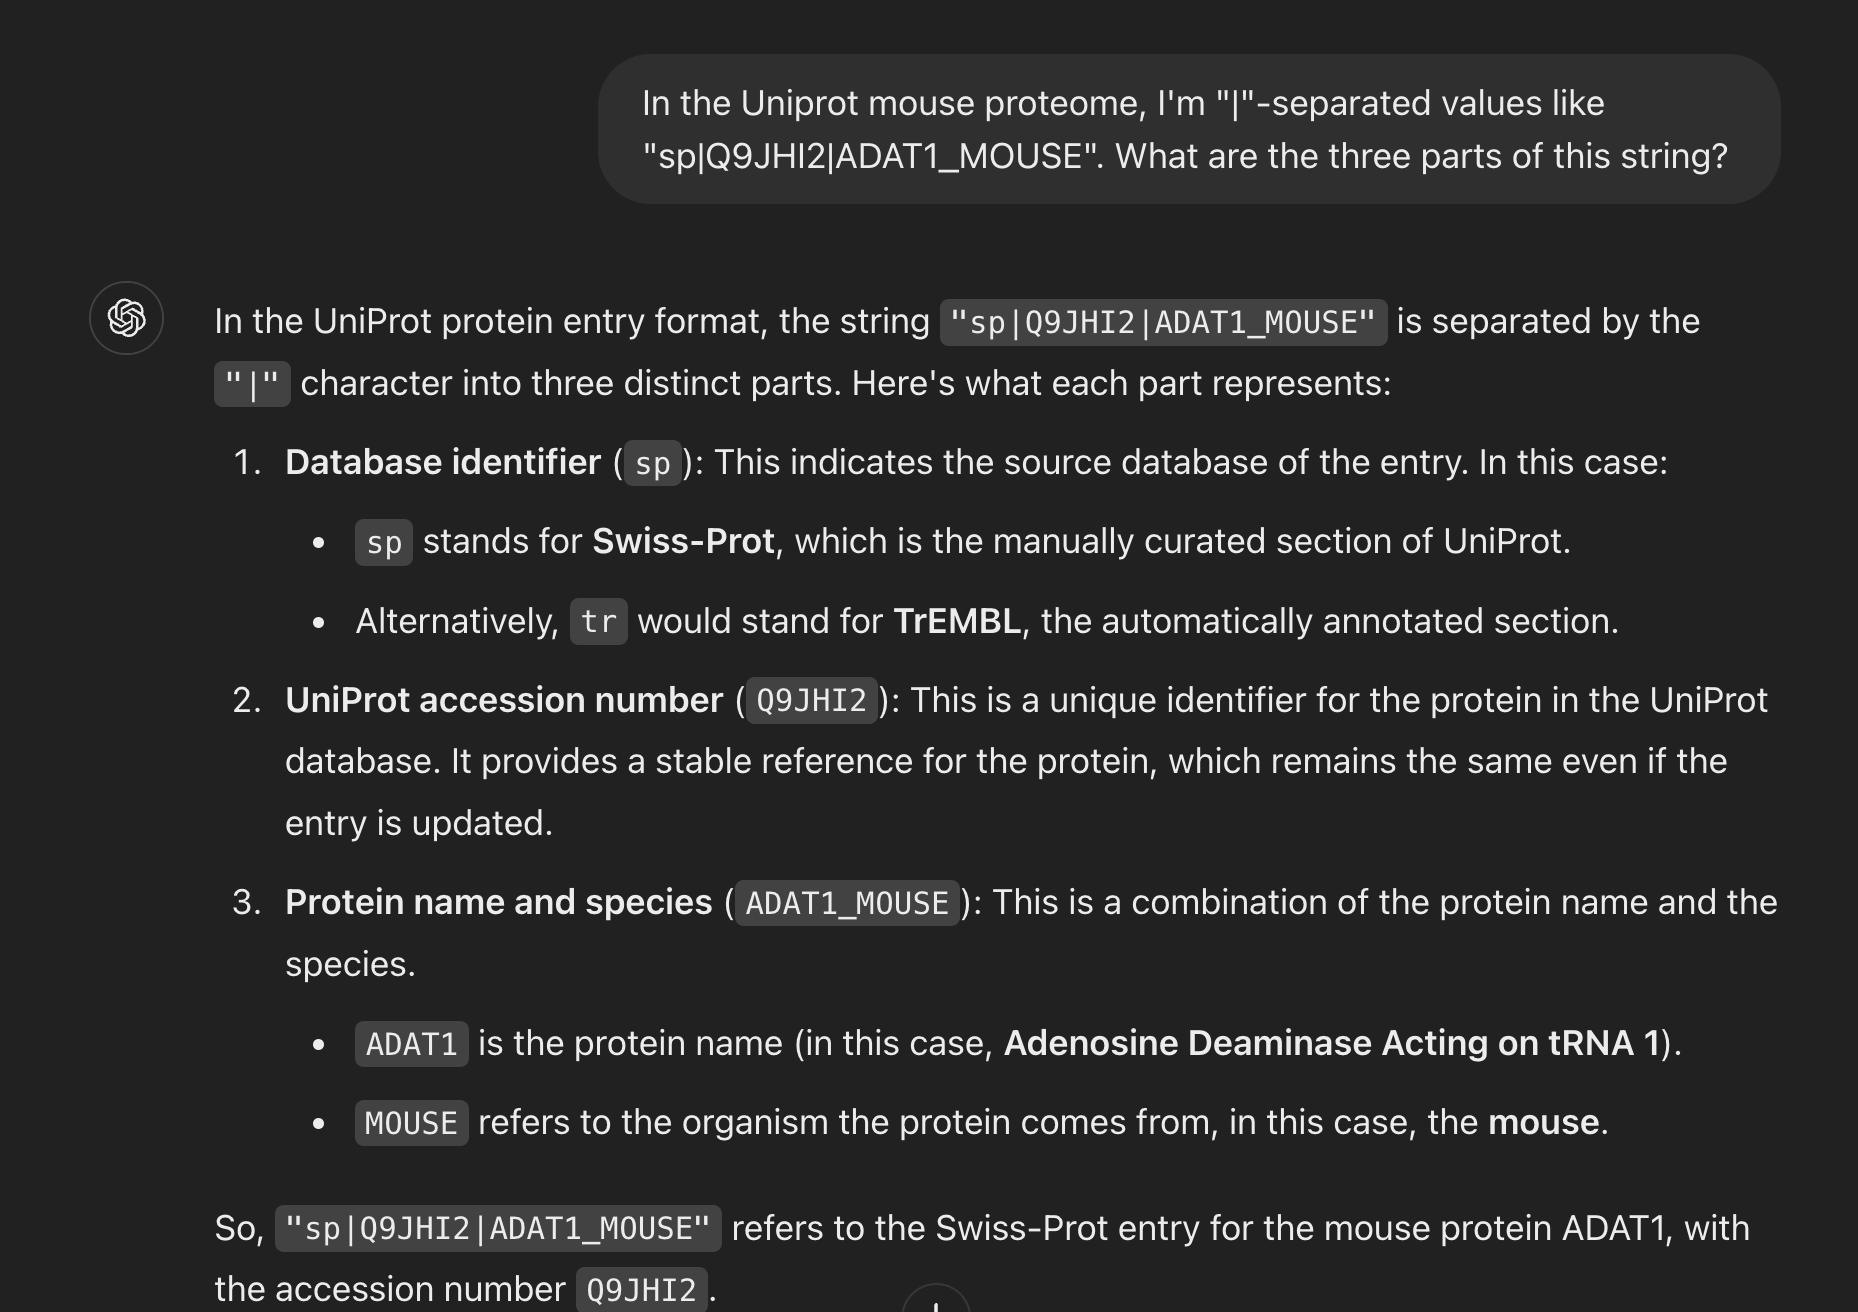

- 

## Distribution of 

# Notes
## Th, Oct 31, 2024 (Happy Halloween!)
## Questions

1. How exactly are HS's "total score", "total abundance", "b score", "y score" computed?
2. What makes HS output two or more kmers separated by "/"?
3. How to match spectrum id across comet run 1, comet run 2, and HS output?
4. How do native scores compare to hybrid peptide scores?
5. How do they do the mapping from Comet peptide output + proteins containing that peptide to exactly where in the protein to align the peptide?

## To dos

- [ ] Get list of proteins that should be in Comet run 1 data from Thomas
- [x] Email Comet group about running Comet on just one (or a few) spectra
    - [link](https://groups.google.com/g/comet-ms/c/Slhys85gov4)
- [ ] Look at distribution of how many possible explanations there are for every mass; Ryan had hoped there would be a drop off in number of explanations for each mass but unfortunately that's not what they've seen; so now what would your priors be to get over that;
- [ ] 

In [ ]:
import sqlite3
import time

# Connect to SQLite database (or create a new one)
connection = sqlite3.connect(':memory:')  # Using an in-memory database
cursor = connection.cursor()

# Create a sample table
cursor.execute('''
CREATE TABLE sales (
    customer_id INTEGER,
    product_id INTEGER,
    sale_date DATE,
    amount REAL
);
''')

# Insert some sample data
sample_data = [(i, j, f"2024-11-{i % 30 + 1}", i * 100.0) for i in range(1, 1001) for j in range(1, 6)]
cursor.executemany('INSERT INTO sales (customer_id, product_id, sale_date, amount) VALUES (?, ?, ?, ?);', sample_data)

# Function to measure query time
def measure_query_time(query):
    start_time = time.time()
    cursor.execute(query)
    result = cursor.fetchall()
    end_time = time.time()
    return end_time - start_time

# Function to run a query and measure the time without any index
def run_query_without_index():
    query = '''
    SELECT * FROM sales
    WHERE customer_id = 500 AND product_id = 3;
    '''
    return measure_query_time(query)

# Function to run a query and measure the time with an index
def run_query_with_index():
    # Create a composite index on customer_id and product_id
    cursor.execute('CREATE INDEX idx_customer_product ON sales (customer_id, product_id);')
    
    query = '''
    SELECT * FROM sales
    WHERE customer_id = 500 AND product_id = 3;
    '''
    query_time = measure_query_time(query)
    
    # Clean up the index after the query
    cursor.execute('DROP INDEX idx_customer_product;')
    
    return query_time

# Function to run a query and measure the time with a composite index with swapped order
def run_query_with_swapped_index():
    # Create a composite index on product_id and customer_id
    cursor.execute('CREATE INDEX idx_product_customer ON sales (product_id, customer_id);')
    
    query = '''
    SELECT * FROM sales
    WHERE customer_id = 500 AND product_id = 3;
    '''
    query_time = measure_query_time(query)
    
    # Clean up the index after the query
    cursor.execute('DROP INDEX idx_product_customer;')
    
    return query_time

# Running and measuring query times
print("Query without index:")
time_without_index = run_query_without_index()
print(f"Time without index: {time_without_index:.6f} seconds")

print("\nQuery with composite index (customer_id, product_id):")
time_with_index = run_query_with_index()
print(f"Time with index (customer_id, product_id): {time_with_index:.6f} seconds")

print("\nQuery with composite index (product_id, customer_id):")
time_with_swapped_index = run_query_with_swapped_index()
print(f"Time with index (product_id, customer_id): {time_with_swapped_index:.6f} seconds")

# Clean up and close the connection
connection.close()

# PPM vs Dalton

In [ ]:
def ppm(ref_mass_in_da, mass_diff_in_da):
    return abs(mass_diff_in_da / ref_mass_in_da) * (10**6)
ppm(100, 0.1)
ppm(1000, 0.1)

1000.0

100.0